# Image Captioning with Transformers

In [ ]:
!nvidia-smi

Fri Jun 25 22:52:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!apt install -qq pigz
%pip install -q timm wandb
%pip install -q --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

The following NEW packages will be installed:
  pigz
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 57.4 kB of archives.
After this operation, 259 kB of additional disk space will be used.
Selecting previously unselected package pigz.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../archives/pigz_2.4-1_amd64.deb ...
Unpacking pigz (2.4-1) ...
Setting up pigz (2.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 348kB 14.7MB/s 
     |████████████████████████████████| 1.8MB 25.5MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 174kB 52.2MB/s 
     |████████████████████████████████| 133kB 50.8MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 613.6MB 26kB/s 


In [ ]:
!git clone https://github.com/ShivamShrirao/Image-Captioning-Transformers

Cloning into 'Image-Captioning-Transformers'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 31 (delta 8), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (31/31), done.


# Download Dataset and Annotations

In [ ]:
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shivamshrirao/coco-trainval2017-320x320

In [ ]:
!unzip -q coco-trainval2017-320x320.zip

In [ ]:
# !gdown --id 1-3vdwBlY-CdVultkrFwOhyJTGC5TFUV8

In [ ]:
# !pigz -dc coco_trainval2017_320x320.tar.gz | tar xf -

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive
DATA_DIR = "datasets/COCO"

In [ ]:
download_and_extract_archive("http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
                             download_root=DATA_DIR,
                             remove_finished=True)


Extracting datasets/COCO/annotations_trainval2017.zip to datasets/COCO


In [ ]:
!rm coco_trainval2017_320x320.tar.gz datasets/COCO/annotations_trainval2017.zip

In [ ]:
!mkdir /content/datasets/COCO/train
!mkdir /content/datasets/COCO/val
!mv /content/datasets/COCO/train2017 /content/datasets/COCO/train/
!mv /content/datasets/COCO/val2017 /content/datasets/COCO/val/

# Import libraries

In [1]:
%cd Image-Captioning-Transformers

/content/Image-Captioning-Transformers


In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
# TODO: Try pre trained CLIP

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms as T

In [5]:
import math
import random
from random import randint
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import OrderedDict

In [6]:
import timm

In [7]:
plt.rcParams['figure.facecolor'] = 'white'

In [8]:
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = True
    
seed_everything()

# Preprocessing Transforms

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
input_size = 224

In [11]:
# first transform crop while loading, then do rest later in batch on device
preproc = {
    'train': T.Compose([
        T.RandomResizedCrop(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.RandomHorizontalFlip(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
        T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## Read COCO dataset

In [12]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.io import read_file, decode_jpeg, ImageReadMode
import torchtext
import os

In [13]:
DATA_DIR = "../datasets/COCO/"

In [14]:
class TensorCocoCaptions(datasets.CocoCaptions):
    def __getitem__(self, index: int):
        return super().__getitem__(index % len(self.ids))

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        data = read_file(os.path.join(self.root, path))
        return data
        # return decode_jpeg(data, ImageReadMode.RGB)#, device=DEVICE)

In [15]:
train_data = TensorCocoCaptions(root=DATA_DIR+"/train/train2017/",
                                annFile=DATA_DIR+"/annotations/captions_train2017.json")

val_data = TensorCocoCaptions(root=DATA_DIR+"/val/val2017/",
                              annFile=DATA_DIR+"/annotations/captions_val2017.json")

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


## Tokenizer and Build Vocab

In [16]:
tokenizer = get_tokenizer('basic_english')

In [17]:
def yield_tokens(cap_data):
    for ann in cap_data.coco.anns.values():
        yield tokenizer(ann['caption'])

In [18]:
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
en_vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=special_symbols, special_first=True)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = en_vocab(special_symbols)
en_vocab.set_default_index(UNK_IDX)

In [19]:
len(en_vocab)

28940

## Pretrained Glove Embeddings (not used rn)

In [20]:
# vec = torchtext.vocab.GloVe('6B', dim=300)
# unk_vec = vec.vectors.mean(dim=0)
# vec.unk_init = lambda x: unk_vec

In [21]:
# vec.get_vecs_by_tokens(tokens, lower_case_backup=True)

# Model Parameters

In [22]:
import wandb

In [23]:
config_defaults = {
    'tgt_vocab_size'    : len(en_vocab),
    'BATCH_SIZE'        : 256,
    'd_model'           : 512,
    'dim_feedforward'   : 2048,
    'nheads'            : 8,
    'num_decoder_layers': 6,
    'dp_rate'           : 0.1,
    'encoder'           : 'seresnext50_32x4d',
    'activation'        : 'gelu',
    'ilr'               : 1,
    'betas'             : (0.9, 0.98),
    'eps'               : 1e-9,
    'use_amp'           : True,
    'use_pe'            : True,
    'log_interval'      : 5,
}
CONFIG = config_defaults

In [24]:
# #hide
# run = wandb.init(id='2ukzgoja', project="Image_Captioning_Transformer", resume='must')
# CONFIG = run.config

In [25]:
run = wandb.init(project="Image_Captioning_Transformer", entity="shivamshrirao", config=config_defaults)
CONFIG = wandb.config

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


# Load dataset into batches

In [26]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIClassificationIterator
from random import shuffle

In [27]:
class ExternalInputIterator(object):
    def __init__(self, dataset, batch_size, training=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.training = training
        if self.training: shuffle(train_data.ids)

    def __iter__(self):
        self.idx = 0
        if self.training: shuffle(train_data.ids)
        return self

    def __next__(self):
        img_batch = []
        cap_batch = []

        if self.idx >= len(self.dataset):
            self.__iter__()
            raise StopIteration

        for _ in range(self.batch_size):
            img, caps = self.dataset[self.idx]
            img_batch.append(img)
            cap = caps[randint(0,len(caps)-1) if self.training else 0]
            cap_batch.append(torch.tensor([BOS_IDX] + en_vocab(tokenizer(cap)) + [EOS_IDX]))
            self.idx += 1
        cap_batch = pad_sequence(cap_batch, batch_first=True, padding_value=PAD_IDX)
        return (img_batch, cap_batch)

    def __len__(self):
        return len(self.dataset)
        return math.ceil(len(self.dataset)/self.batch_size)

    next = __next__

In [28]:
def ExternalSourcePipeline(batch_size, num_threads, device_id, external_data, training=True):
    pipe = Pipeline(batch_size, num_threads, device_id)
    with pipe:
        images, labels = fn.external_source(source=external_data, num_outputs=2)
        if training:
            images = fn.decoders.image_random_crop(images, device='mixed', output_type=types.RGB, num_attempts=100)
            mirror = fn.random.coin_flip(probability=0.5)
        else:
            images = fn.decoders.image(images, device='mixed', output_type=types.RGB)
            mirror = False
        images = fn.resize(images, device='gpu', resize_shorter=input_size, interp_type=types.INTERP_TRIANGULAR)
        images = fn.crop_mirror_normalize(images.gpu(),
                                          dtype=types.FLOAT,
                                          output_layout="CHW",
                                          crop=(input_size, input_size),
                                          mean=[0.485 * 255,0.456 * 255,0.406 * 255],
                                          std=[0.229 * 255,0.224 * 255,0.225 * 255],
                                          mirror=mirror)
        labels = labels.gpu()
        pipe.set_outputs(images, labels)
    return pipe

In [ ]:
train_iter = ExternalInputIterator(train_data, CONFIG['BATCH_SIZE'])
pipe = ExternalSourcePipeline(batch_size=CONFIG['BATCH_SIZE'], num_threads=4, device_id = 0, external_data = train_iter)
train_loader = DALIClassificationIterator(pipe, dynamic_shape=True, auto_reset=True, last_batch_padded=True, size=len(train_iter))

val_iter = ExternalInputIterator(val_data, CONFIG['BATCH_SIZE'], training=False)
pipe = ExternalSourcePipeline(batch_size=CONFIG['BATCH_SIZE'], num_threads=4, device_id = 0, external_data = val_iter, training=False)
val_loader = DALIClassificationIterator(pipe, dynamic_shape=True, auto_reset=True, last_batch_padded=True, size=len(val_iter))

# Initialize Model

In [30]:
from imcap.layers import *
from imcap.utils import *

In [31]:
# inp = torch.randn((1,3,224,224))

In [32]:
encoder = timm.create_model(CONFIG['encoder'], pretrained=True, num_classes=0, global_pool='')

In [33]:
# out = encoder(inp).flatten(-2).permute(2,0,1)
# out.shape

In [34]:
# ph = ProjectionHead()
# ph(out).shape

In [35]:
model = CaptionModel(encoder = encoder,
                     vocab_size = CONFIG['tgt_vocab_size'],
                     num_decoder_layers = CONFIG['num_decoder_layers'],
                     nheads = CONFIG['nheads'],
                     d_model = CONFIG['d_model'],
                     dim_feedforward = CONFIG['dim_feedforward'],
                     dp_rate = CONFIG['dp_rate'],
                     activation = CONFIG['activation']).to(DEVICE, non_blocking=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [36]:
# img, cap = next(iter(train_loader))
# img = img.to(DEVICE)
# cap = cap.to(DEVICE)

In [37]:
# tgt_mask, tgt_pad_mask = subsequent_mask(cap.size(0), DEVICE), padding_mask(cap, PAD_IDX)
# tgt_mask.shape, tgt_pad_mask.shape

In [38]:
# with torch.no_grad():
#     o = model(img, cap, tgt_mask, tgt_pad_mask)
# o.shape

# Learning Rate Schedule

In [39]:
steps_per_epoch = len(train_loader)

In [40]:
def lr_schedule(step, d_model=512, warmup_steps=2*steps_per_epoch):
    # return 1
    step = max(1,step)
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    return (d_model ** -0.6) * min(arg1, arg2)

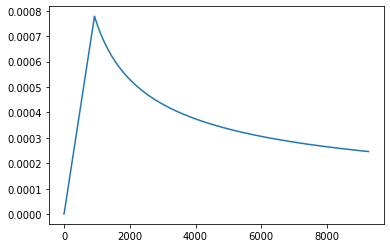

In [41]:
plt.plot(list(map(lr_schedule, range(steps_per_epoch*20))))
plt.show()

# Loss Function and Optimizer

In [42]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['ilr'], betas=CONFIG['betas'], eps=CONFIG['eps']
)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

# Log model

In [43]:
# from torch.utils.tensorboard import SummaryWriter

In [44]:
# writer = SummaryWriter(run.dir+'/tensorboard_logs/imcap')

In [45]:
# img, tgt = next(iter(train_loader))
# img = img.to(DEVICE)
# tgt = tgt.to(DEVICE)
# with torch.no_grad():
#     model(img, tgt)
# writer.add_graph(model, (img, tgt))
# writer.close()
# del img, tgt

In [46]:
wandb.watch(model, log=None)

# Training functions

In [47]:
from torch.cuda import amp

In [48]:
def train_epoch(model, train_loader, optimizer, scaler, scheduler, epoch=1, use_amp=True, log_interval=10):
    model.train()
    model.encoder.eval()
    losses = 0
    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}") as pbar:
        for idx, batch in pbar:
            img, tgt = batch[0]['data'], batch[0]['label'].transpose(0,1)
            # img = img.to(DEVICE, non_blocking=True)
            # tgt = tgt.to(DEVICE, non_blocking=True)
            
            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0), DEVICE), padding_mask(tgt_inp, PAD_IDX)

            optimizer.zero_grad(set_to_none=True)
            with amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            losses+= loss.detach()
            curr_lr = optimizer.param_groups[0]['lr']
            info = {'loss': losses/(idx+1), 'lr': curr_lr}

            if not idx%log_interval: wandb.log(info)
            pbar.set_postfix(info)

    optimizer.zero_grad(set_to_none=True)
    return losses/len(train_loader)

In [49]:
def evaluate(model, val_loader, use_amp=True):
    model.eval()
    losses = 0
    with tqdm(enumerate(val_loader), total=len(val_loader), desc="Evaluating") as pbar:
        for idx, batch in pbar:
            img, tgt = batch[0]['data'], batch[0]['label'].transpose(0,1)
            # img = img.to(DEVICE, non_blocking=True)
            # tgt = tgt.to(DEVICE, non_blocking=True)


            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0), DEVICE), padding_mask(tgt_inp, PAD_IDX)
            
            with amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            losses+= loss.detach()
            pbar.set_postfix({'val_loss': losses/(idx+1)})
    return losses/len(val_loader)

In [50]:
# def save_model(model, optimizer, epoch):
#     torch.save({
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'epoch': epoch,
#                 }, run.dir + '/model.pth')

# Functions to Make Predictions

In [59]:
def greedy_decode(model, img, max_len=100, start_symbol=BOS_IDX):
    model.eval()
    img = img.to(DEVICE, non_blocking=True)
    enc_output = model.encode_image(img)
    tgt = torch.ones(1, 1).fill_(start_symbol).long().to(DEVICE, non_blocking=True)
    for i in range(max_len):
        tgt_mask = subsequent_mask(tgt.size(0), DEVICE)
        out = model.decode_text(tgt, enc_output, tgt_mask)
        out = out.transpose(0,1)
        prob = model.generator(out[:,-1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        tgt = torch.cat([tgt, torch.ones(1, 1).fill_(next_word).long().to(DEVICE)], dim=0)
        if next_word == EOS_IDX:
            break
    return tgt.detach()

def generate_caption(model, img, tgt_vocab):
    with torch.no_grad():
        tgt = greedy_decode(model, img, max_len=100, start_symbol=BOS_IDX).flatten()
    return " ".join(tgt_vocab.lookup_tokens(tgt.tolist())).replace("<bos>", "").replace("<eos>", "")

# Begin Training

In [51]:
init_epoch = 1

In [52]:
NUM_EPOCHS = 50

In [58]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [60]:
import glob
val_paths = glob.glob("../datasets/COCO/val/val2017/*")

In [ ]:
#collapse-output
for epoch in range(init_epoch, NUM_EPOCHS+1):
    train_loss = train_epoch(model, train_loader, optimizer, scaler, scheduler,
                             epoch, CONFIG['use_amp'], CONFIG['log_interval'])
    gc.collect()
    with torch.no_grad():
        val_loss = evaluate(model, val_loader, CONFIG['use_amp'])
    
    img = Image.open(random.choice(val_paths))
    caps = generate_caption(model, preproc['val'](img)[None,:], en_vocab)
    wandb.log({"val_loss": val_loss, "epoch": epoch, "examples": wandb.Image(img, caption=caps)})
    # LOG EXAMPLE IMAGE AND CAPTIONS TO WANDB
    print(f"Epoch: {epoch}/{NUM_EPOCHS}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}\n")
    # if not epoch%10:
    #     save_model(model, optimizer, epoch)


Epoch: 11/50, Train loss: 2.170, Val loss: 2.057




Epoch: 12/50, Train loss: 2.202, Val loss: 2.042




Epoch: 13/50, Train loss: 2.181, Val loss: 2.030



In [57]:
init_epoch = epoch
init_epoch

11

# Make Predictions

 a person holding a sandwich in their hands . 


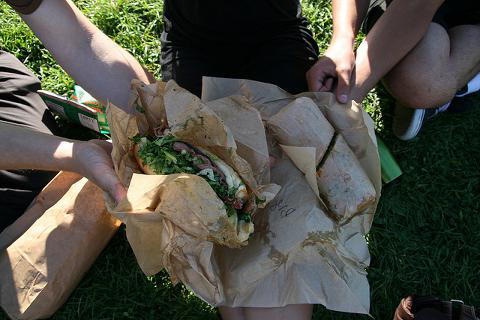

In [68]:
img = Image.open(random.choice(val_paths))
caps = generate_caption(model, preproc['val'](img)[None,:], en_vocab)
wandb.log({"val_loss": val_loss, "epoch": epoch, "examples": wandb.Image(img, caption=caps)})
print(caps)
img